<a href="https://colab.research.google.com/github/SohailaDiab/365-Days-of-AI/blob/main/Evaluation_Metrics_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


# 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
!wget $data -O data-week-3.csv

--2022-10-14 06:08:53--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  --.-KB/s    in 0.007s  

2022-10-14 06:08:53 (132 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



In [5]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

# 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

Accuracy tells us about the fraction of correct predictions.



```
correct predictions / total predictions
```



In [10]:
len(y_val)

1409

In [11]:
(y_val ==  churn_decision).mean()

0.8034066713981547

In [12]:
# Accuracy
1132/1409

0.8034066713981547

In [13]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
  churn_decision = (y_pred >= t)
  # score = accuracy_score(y_val, y_pred >= t) ....with sklearm
  score = (y_val == churn_decision).mean()
  print('%.2f %.3f' % (t, score))
  scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


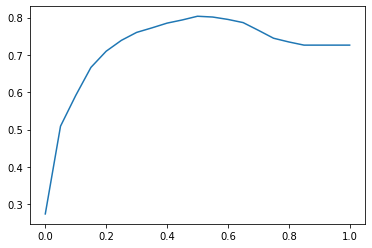

In [14]:
plt.plot(thresholds, scores);

## Class Imbalance

We have a lot more customers who are non churning than churning ones.

In cases like this, if we predict a majority class (predict all will not churn), the model will have a good accuracy.

This is why accuracy can be misleading for cases with class imbalance.


# 4.3 Confusion Matrix
- Different types of errors and correct decisions
- Arranging them in a table

It is a way of looking at different errors the binary classification model makes.

We can get a better understanding of what kind of correct and incorrect decisions the model makes.

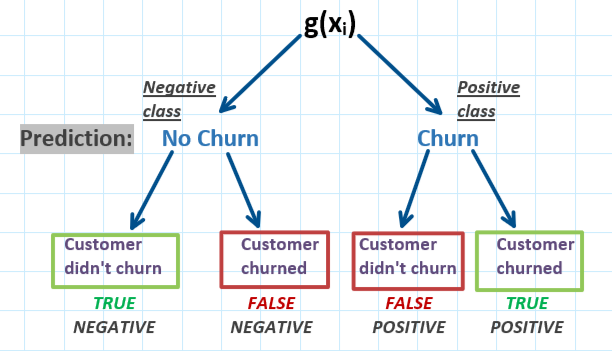

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
# True predictions
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [22]:
# False predictions
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

## Confusion Table

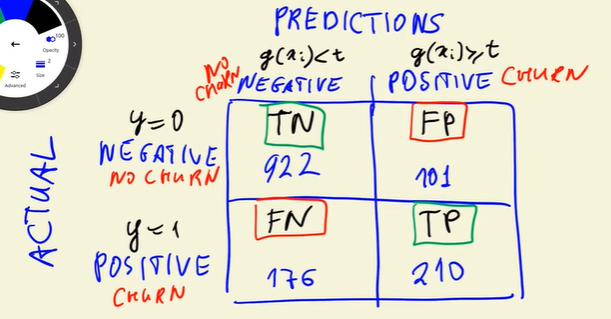

In [23]:
# Confusion Table
confusion_matrix = np.array([[tn, fp],
                             [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

We have a lot more false negatives than false positives. 

- **False positives** would be people who get the discount email even though they weren't going to churn. (Losing money).

- **False negatives** would be people who did not get a discount email, and they were going to churn, so they leave. (Losing customers/profit)

## Normalizing confusion matrix (having percentages instead)

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

### Accuracy 
Accuracy = (TP + TN) / (TP + TN + FP + FN)

Accuracy = 80% = 65%+18%

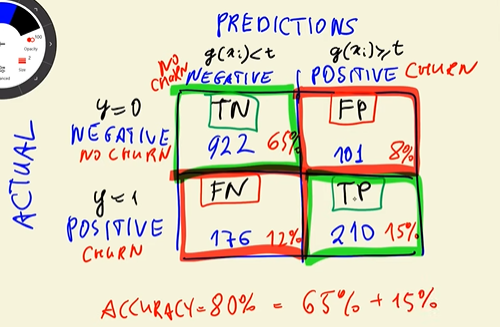

# 4.4 Precision and Recall
Metrics for evaluating binary classification models.

## Precision
**Fraction of positive predictions that are correct.**

- We predict that some customers are churning, and out of those we will get the ones that were identified correctly.

*We are only interested in the positive class (ones that predicted they'll churn)*




$Precision = \frac{ True Positive }{ Total Positive Predictions } = \frac{ True Positive }{ True Positive + False Positive } $




In [27]:
p = tp/(tp+fp)
p, tp+fp

(0.6752411575562701, 311)

> **Percision is 67%**

This means that we will send the promotional email to `311` people, and only `210` of them were going to actually churn.

Approximately `33%` were not supposed to receive the promotional emails.

## Recall
**Fraction of correctly identified positive examples.** ... Correctly identified churning users.

*We are only interested in **TP and FN** (which is basically the customers that we predicted will be in the positive class (churn))*


$Recall = \frac{ True Positive }{ Total Positive Observations } = \frac{ True Positive }{ True Positive + False Negative } $

In [29]:
r = tp / (tp+fn)
r, tp+fn

(0.5440414507772021, 386)

> **Recall is 54%**

This means we fail to identify `46%` of people who churn.

## Summary

**Accuracy is misleading!** 

Especially in cases where we have class imbalance like this one (churn prediction).

We had a `80%` accuracy, which seems like the model is pretty accurate.

However, when we look at precision and recal, we find out that the model is not very good.

The purpose is to identify churning users, and for this purpose accuracy is not the best metric. 

We **failed to identify 46% churning users** (*recall*) and **sent promotional emails to 33% of users who were not going to churn** (*precision*).

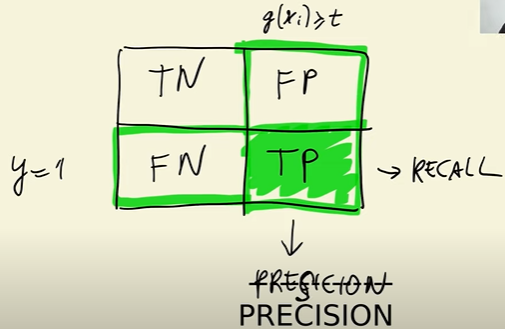

### Precision
Look at all the customers we thing are going to churn.

$Precision = \frac{ True Positive }{ True Positive + False Positive } $

### Recall
Look at all the customers that are actually churning.

$Recall = \frac{ True Positive }{ True Positive + False Negative } $